# 2D Burger's LaSDI-NM Example

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy import sparse as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from itertools import product
import sys,time
import os
import pickle
sys.path.append("..") # Adds higher directory to python modules path.
from LaSDI import LaSDI

In [2]:
!nvidia-smi
torch.cuda.empty_cache()

Thu Sep 30 09:50:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   38C    P0    53W / 300W |   6836MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   40C    P0    36W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### Load Necessary simulations and models from Build and Train files.

In [3]:
LS_dim = 3
snapshot_file = './data/snapshot_git.p'
model_file_u = './model/AE_u_git.tar'
model_file_v = './model/AE_v_git.tar'
FOM_file = './data/FOM.p' 

In [4]:
# Set print option
np.set_printoptions(threshold=sys.maxsize)

# Choose device that is not being used
gpu_ids = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

# Given parameters
nx = 60
ny = 60
m = (ny-2)*(nx-2) # 3364
nt = 1500
tstop = 2
dt = tstop/nt
t = np.linspace(0,tstop,nt)

# In[17]:


# Choose either Re=10000 or Re=100
Re = 10000 
    
# Choose data normalize option (option 1: -1<=X<=1 option 2: 0<=X<=1)
option = 2

# Choose activation function (sigmoid, swish)
activation = 'sigmoid'


# set the number of nodes in each layer
a = 2
b = int(100)
db = int(10)

M1 = int(a*m) # encoder hidden layer
M2 = b + (m-1)*db # decoder hidden layer

f = LS_dim # latent dimension

def create_mask_2d(m,b,db):
    
    # local
    Mb=sp.diags([np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
    M=sp.kron(sp.eye(ny-2),Mb,format="csr")

    Ib=sp.eye(nx-2)
    N=sp.kron(sp.diags([np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

    local=(M+N).astype('int8')
    I,J,V=sp.find(local)
    local[I,J]=1

    # basis
    M2 = int(b + db*(m-1))
    basis = np.zeros((m,M2),dtype='int8')

    block = np.ones(b,dtype='int8')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        basis[row,col] = block
    
    # mask
    col_ind=np.array([],dtype='int8')
    row_ind=np.array([],dtype='int8')
    for i in range(m):
        col=basis[sp.find(local[i])[1]].sum(axis=0).nonzero()[0]
        row=i*np.ones(col.size)

        col_ind=np.append(col_ind,col)
        row_ind=np.append(row_ind,row)

    data=np.ones(row_ind.size,dtype='int8')
    mask=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,M2)).toarray()
    
    print(
        "Sparsity in {} by {} mask: {:.2f}%".format(
            m, M2, (1.0-np.count_nonzero(mask)/np.prod(mask.shape))*100
        )
    )
    
    return mask
mask_2d=create_mask_2d(m,b,db)


if activation=='sigmoid':
    class Encoder(nn.Module):
        def __init__(self,m,M1,f):
            super(Encoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(m,M1),
                nn.Sigmoid(),
                nn.Linear(M1,f,bias=False)
            )

        def forward(self, y):     
            y = y.view(-1,m)
            T = self.full(y)
            T = T.squeeze()

            return T

    class Decoder(nn.Module):
        def __init__(self,f,M2,m):
            super(Decoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(f,M2),
                nn.Sigmoid(),
                nn.Linear(M2,m,bias=False)
            )

        def forward(self,T):
            T = T.view(-1,f)
            y = self.full(T)
            y = y.squeeze()

            return y
        
elif activation=='swish':
    def silu(input):
        return input * torch.sigmoid(input)

    class SiLU(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, input):
            return silu(input)
        
    class Encoder(nn.Module):
        def __init__(self,m,M1,f):
            super(Encoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(m,M1),
                SiLU(),
                nn.Linear(M1,f,bias=False)
            )

        def forward(self, y):     
            y = y.view(-1,m)
            T = self.full(y)
            T = T.squeeze()

            return T

    class Decoder(nn.Module):
        def __init__(self,f,M2,m):
            super(Decoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(f,M2),
                SiLU(),
                nn.Linear(M2,m,bias=False)
            )

        def forward(self,T):
            T = T.view(-1,f)
            y = self.full(T)
            y = y.squeeze()

            return y
else:
    raise NameError('{} is given for option, but it must be either sigmoid or swish'.format(activation))

Using device: cuda 

Sparsity in 3364 by 33730 mask: 99.06%


In [5]:
model_u = torch.load(model_file_u, map_location=device)    
encoder_u = Encoder(m,M1,f).to(device); decoder_u = Decoder(f,M2,m).to(device)
prune.custom_from_mask(decoder_u.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))    
encoder_u.load_state_dict(model_u['encoder_state_dict']); decoder_u.load_state_dict(model_u['decoder_state_dict'])


model_v = torch.load('../../../../../usr/WS1/fries4/Experiments/2DBurgers/model/AE_v_git.tar', map_location=device)    
encoder_v = Encoder(m,M1,f).to(device); decoder_v = Decoder(f,M2,m).to(device)
prune.custom_from_mask(decoder_v.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))    
encoder_v.load_state_dict(model_v['encoder_state_dict']); decoder_v.load_state_dict(model_v['decoder_state_dict'])

<All keys matched successfully>

In [6]:
snapshot = pickle.load(open(snapshot_file, 'rb'))

snapshot_u = snapshot['u'].reshape(-1,nx*ny).astype('float32')
snapshot_v = snapshot['v'].reshape(-1,nx*ny).astype('float32')
ndata = snapshot_u.shape[0]

nset = round(ndata/(nt+1))

# remove BC
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

orig_data_u = snapshot_u[:,free_raveled_indicies]
orig_data_v = snapshot_v[:,free_raveled_indicies]

[xv,yv]=np.meshgrid(np.linspace(-3,3,nx),np.linspace(-3,3,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

### Generate Latent-Space Trajectories for Training Data

In [7]:
latent_space_SS_u = []
latent_space_SS_v = []

for foo in range(nset):
    input_SS_u=torch.tensor(orig_data_u[foo*(nt+1):(foo+1)*(nt+1)]).to(device)
    input_SS_v=torch.tensor(orig_data_u[foo*(nt+1):(foo+1)*(nt+1)]).to(device)
    latent_space_u = encoder_u(input_SS_u).cpu().detach().numpy()
    latent_space_v = encoder_v(input_SS_u).cpu().detach().numpy()
    latent_space_SS_u.append(latent_space_u)
    latent_space_SS_v.append(latent_space_v)

In [8]:
amp_arr = [.75,.85]
width_arr = [.95,1.05]
P = list(product(amp_arr, width_arr))
P = np.array(P)

### Generate LaSDI-NM Models for $U$ and $V$

In [1]:
print('Dynamical System for U')
normal_u = np.amax(np.abs(latent_space_SS_u))
LaSDI_model_u = LaSDI(encoder_u, decoder_u, NN = True, device = 'cuda')
LaSDI_model_u.train_dynamics(latent_space_SS_u, P, dt, degree = 3, include_interaction = True, normal = normal_u)

print('\nDynamical System for V')
normal_v = np.amax(np.abs(latent_space_SS_v))
LaSDI_model_v = LaSDI(encoder_v, decoder_v, NN = True, device = 'cuda')
LaSDI_model_v.train_dynamics(latent_space_SS_v, P, dt, degree = 3, normal = normal_v, include_interaction = True)

Dynamical System for U


NameError: name 'np' is not defined

## Mapping Parameters to Latent Space

## Interpolation

In [10]:
FOM_high_Re = pickle.load(open(FOM_file,'rb'))
u_full = FOM_high_Re['u']
v_full = FOM_high_Re['v']
time_FOM = FOM_high_Re['t']

u_full = u_full.reshape(-1, nx*ny)
v_full = v_full.reshape(-1,nx*ny)

start = time.time()
FOM_recon_u = LaSDI_model_u.generate_ROM(u_full[0, free_raveled_indicies].astype('float32'), np.array([0.8,1.0]),t)
FOM_recon_v = LaSDI_model_v.generate_ROM(v_full[0, free_raveled_indicies].astype('float32'), np.array([0.8,1.0]),t)
LaSDI_time = time.time()-start

speed_up = time_FOM/LaSDI_time
max_re = np.empty(2)
test = []
for k in range(int(nt)):
    test.append(LA.norm(FOM_recon_u[k].reshape(ny-2,nx-2)-u_full[k,free_raveled_indicies].reshape(ny-2,nx-2))/LA.norm(u_full[k,free_raveled_indicies].reshape(ny-2,nx-2))*100)
max_re[0] = np.amax(test)

test = []
for k in range(int(nt)):
    test.append(LA.norm(FOM_recon_v[k].reshape(ny-2,nx-2)-v_full[k,free_raveled_indicies].reshape(ny-2,nx-2))/LA.norm(v_full[k,free_raveled_indicies].reshape(ny-2,nx-2))*100)
max_re[1] = np.amax(test) 

In [13]:
torch.cuda.empty_cache()

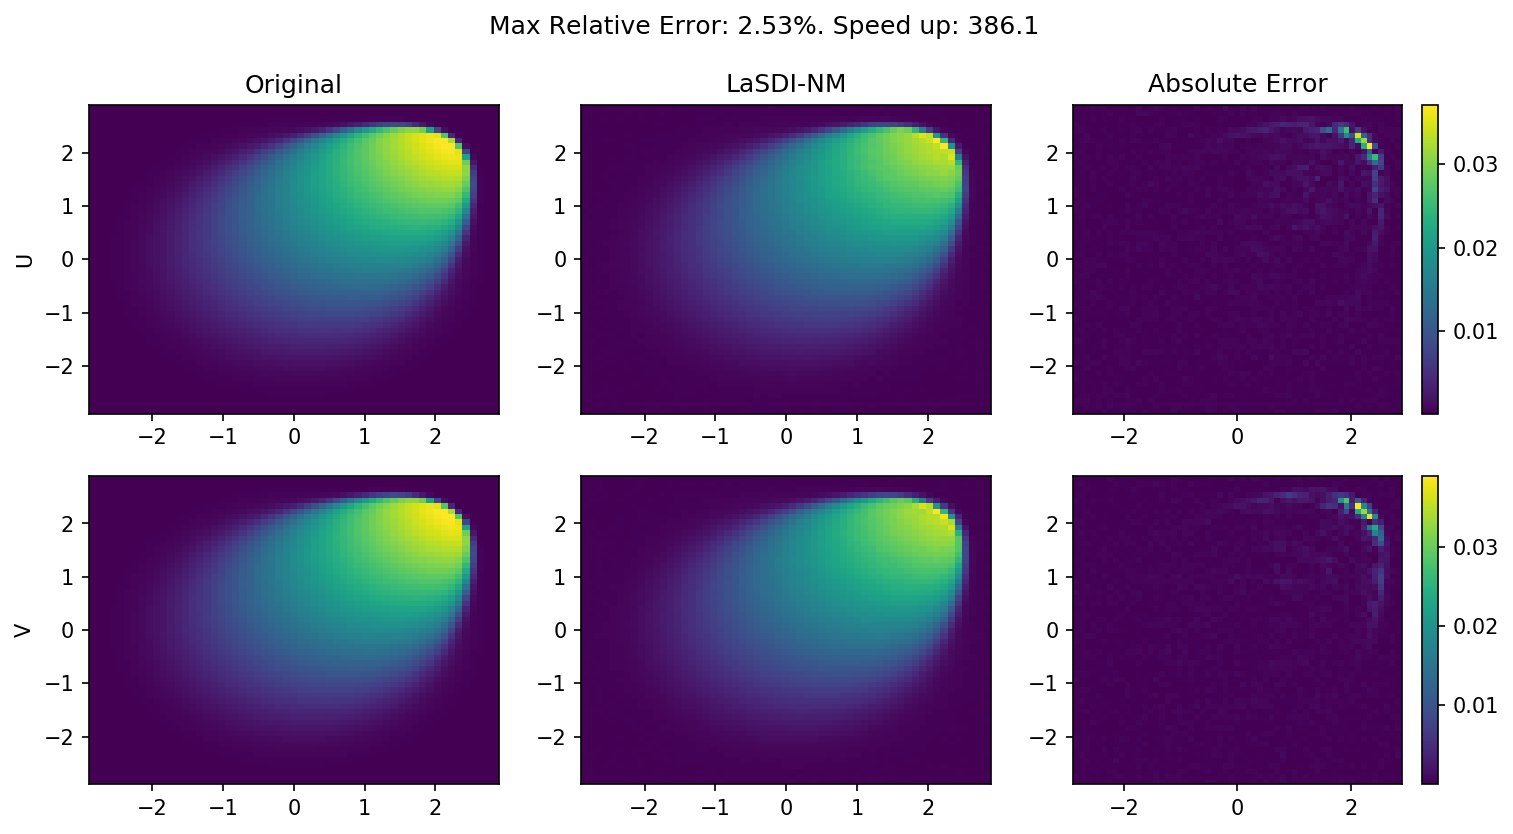

In [14]:
plt.rcParams['figure.dpi'] = 150 
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
fig.set_size_inches(12,6)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),u_full[k,free_raveled_indicies].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax1)
fig.suptitle('Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up))
ax1.set_title('Original')
ax1.set_ylabel('U')

ax2 = fig.add_subplot(2,3,2)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon_u[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax2)
ax2.set_title('LaSDI-NM')

ax3 = fig.add_subplot(2,3,3)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon_u[k].reshape(nx-2,ny-2)-u_full[k,free_raveled_indicies].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax3)
ax3.set_title('Absolute Error')

ax4 = fig.add_subplot(2,3,4)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),v_full[k,free_raveled_indicies].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax4)
ax4.set_ylabel('V')

ax5 = fig.add_subplot(2,3,5)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon_v[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax5)

ax6 = fig.add_subplot(2,3,6)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon_v[k].reshape(nx-2,ny-2)-v_full[k,free_raveled_indicies].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax6)

Text(0, 0.5, 'Relative Error (%)')

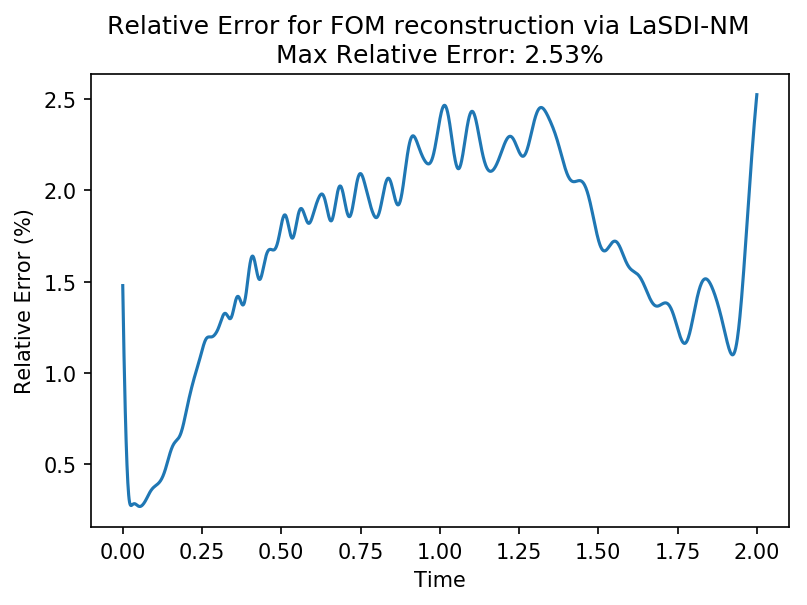

In [16]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-NM')
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(test)))
ax.plot(t, test)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
plt.show()